In [31]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dropout, Dense
from keras.models import Model
from keras import backend as K
from functools import reduce
import theano.tensor as T
import theano

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
plt.style.use('bmh')

# Risk vs. Uncertainty

There are diverse definitions for the distinction between risk and uncertainty.
The most famous comes from Frank Knight, that states:
> Uncertainty must be taken in a sense radically distinct from the familiar notion of Risk, from which it has never been properly separated. The term "risk," as loosely used in everyday speech and in economic discussion, really covers two things which, functionally at least, in their causal relations to the phenomena of economic organization, are categorically different. ... The essential fact is that "risk" means in some cases a quantity susceptible of measurement, while at other times it is something distinctly not of this character; and there are far-reaching and crucial differences in the bearings of the phenomenon depending on which of the two is really present and operating. ... It will appear that a measurable uncertainty, or "risk" proper, as we shall use the term, is so far different from an unmeasurable one that it is not in effect an uncertainty at all. We ... accordingly restrict the term "uncertainty" to cases of the non-quantitive type.

Here we'll use a variant from Ian Osband:
> [...] We identify risk as inherent stochasticity in a model and uncertainty as the confusion over which model parameters apply. For example, a coin may have a fixed $p = 0.5$ of heads and so the outcome of any single flip holds some risk; a learning agent may also be uncertain of $p$.

# The data

We'll use a simulated example for a heteroskedastic random variable $Y$:

$$
y = 2x + 6\sin\left(2\pi x+\frac{\epsilon}{48}\right) \cdot \mathcal{H}(x+2),\\
\epsilon \sim \mathcal{N}\left(0, \ \frac{\pi}{6} + \arctan\left(1.2x + 1\right)\right), \quad x \sim \mathcal{N}(0, 1)
$$

in which $\mathcal{H}$ stands for [Heaviside function](https://en.wikipedia.org/wiki/Heaviside_step_function)

In [4]:
def data_generator(size):
    _x = np.sort(np.random.normal(0, 1, int(size)))
    eps = np.random.normal(0, [-0.5 + 1 / (1 + np.exp(-np.abs(_x))) for x_i in _x], _x.shape)
    _y = _x + np.exp((-_x - 4) * np.pi) + np.abs(_x) * np.sin(np.pi * 2 * (_x + eps / 16)) + eps
    return _x, eps, _y

In [5]:
x, eps, y = data_generator(2000)

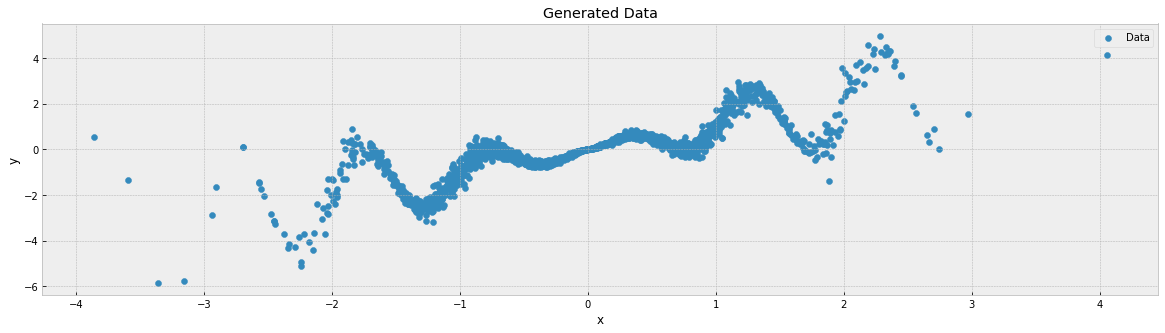

In [6]:
plt.figure(figsize=(20, 5))
plt.scatter(x, y, label='Data')
plt.title('Generated Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show();

/home/willian/notebooks_env/risk-and-uncertainty-deep-learning/env/lib/python3.7/site-packages/seaborn/distributions.py:323: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


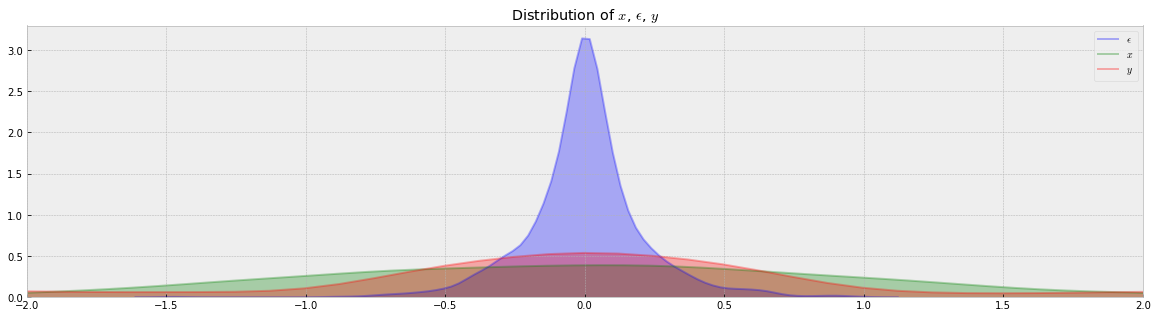

In [7]:
plt.figure(figsize=(20, 5))
sns.kdeplot(eps, alpha=0.3, shade=True, label='$\epsilon$', c='b')
sns.kdeplot(x, alpha=0.3, shade=True, label='$x$', c='g')
sns.kdeplot(y, alpha=0.3, shade=True, label='$y$', c='r')
plt.title('Distribution of $x$, $\epsilon$, $y$')
plt.xlim(-2, 2)
plt.legend()
plt.show();

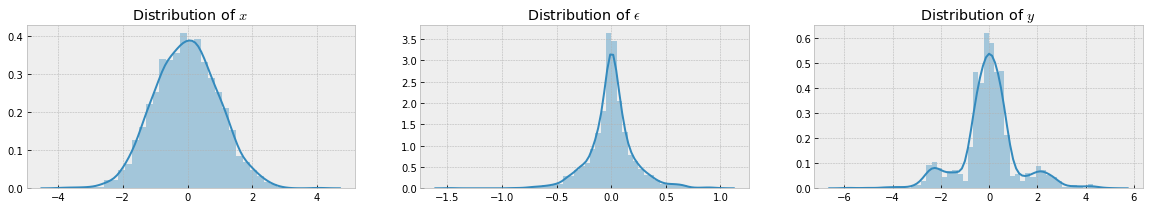

In [8]:
plt.subplots(1, 3, figsize=(20, 3))
plt.subplot(1, 3, 1)
sns.distplot(x)
plt.title('Distribution of $x$')
plt.subplot(1, 3, 2)
sns.distplot(eps)
plt.title('Distribution of $\epsilon$')
plt.subplot(1, 3, 3)
sns.distplot(y)
plt.title('Distribution of $y$')
plt.show();

## Simple Regression

In [9]:
def generate_simple_model():
    i = Input((1,))
    x = Dense(1000, activation='relu')(i)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    o = Dense(1, activation='linear')(x)
    m = Model(i, o)
    return m

In [10]:
x, _, y = data_generator(10000)
simple_model = generate_simple_model()
simple_model.compile(loss='mse', optimizer='adam')
hist = simple_model.fit(x, y, epochs=40, verbose=0)

W0804 17:34:14.901787 140213067085568 deprecation_wrapper.py:119] From /home/willian/notebooks_env/risk-and-uncertainty-deep-learning/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 17:34:14.982840 140213067085568 deprecation_wrapper.py:119] From /home/willian/notebooks_env/risk-and-uncertainty-deep-learning/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 17:34:15.008002 140213067085568 deprecation_wrapper.py:119] From /home/willian/notebooks_env/risk-and-uncertainty-deep-learning/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 17:34:15.117386 140213067085568 deprecation_wrapper.py:119] From /home/willian/notebooks_env/risk-and-uncertai

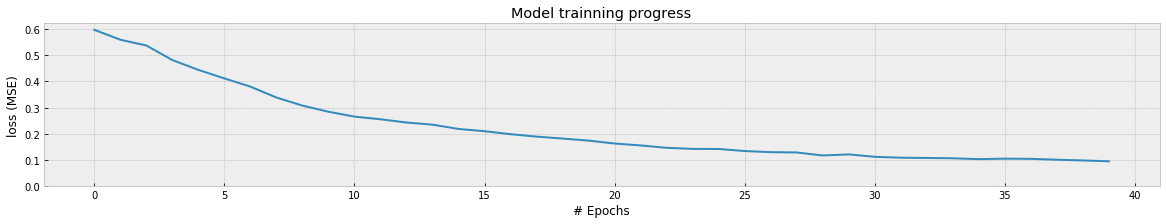

In [11]:
plt.figure(figsize=(20, 3))
plt.plot(hist.history['loss'])
plt.title('Model trainning progress')
plt.xlabel('# Epochs')
plt.ylabel('loss (MSE)')
plt.ylim(0)
plt.show()

In [12]:
_y = simple_model.predict(x)

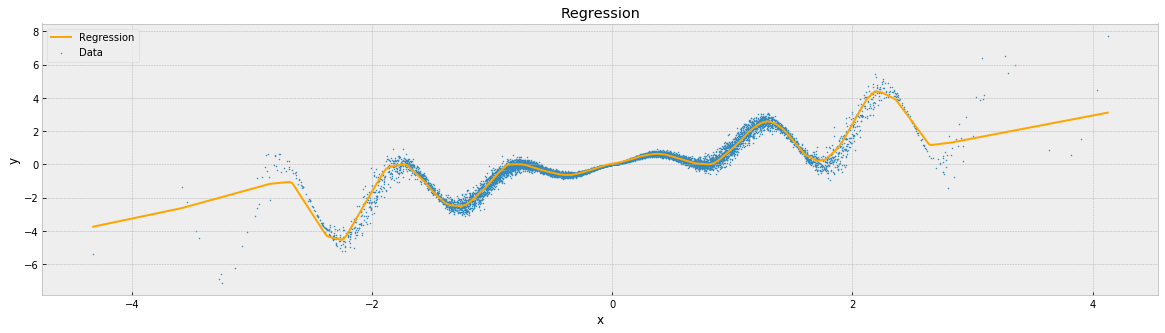

In [13]:
plt.figure(figsize=(20, 5))
plt.scatter(x, y, label='Data', s=1)
plt.plot(x, _y, label='Regression', c='orange')
plt.title('Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show();

# Methods

- variational inference
- Monte Carlo Dropout
- BOOTStRAP

## Markov chain Monte Carlo – Metropolis-Hastings

In [26]:
polynoms_n = range(10)
with pm.Model() as model:
    # Priors
    theta = [pm.Normal(f'theta_{i}', 0, sigma=20) for i in polynoms_n]
    
    # Likelihood
    likelihood = pm.Normal('y', sum([theta[i] * x ** i for i in polynoms_n]),
                        sigma=1, observed=y)
    # Inference!
    trace = pm.sample(10000, cores=3, step=pm.Metropolis())

Sampling 3 chains: 100%|██████████| 31500/31500 [02:26<00:00, 215.68draws/s]
E0804 17:57:51.325195 140213067085568 report.py:143] The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
E0804 17:57:51.326139 140213067085568 report.py:143] The estimated number of effective samples is smaller than 200 for some parameters.


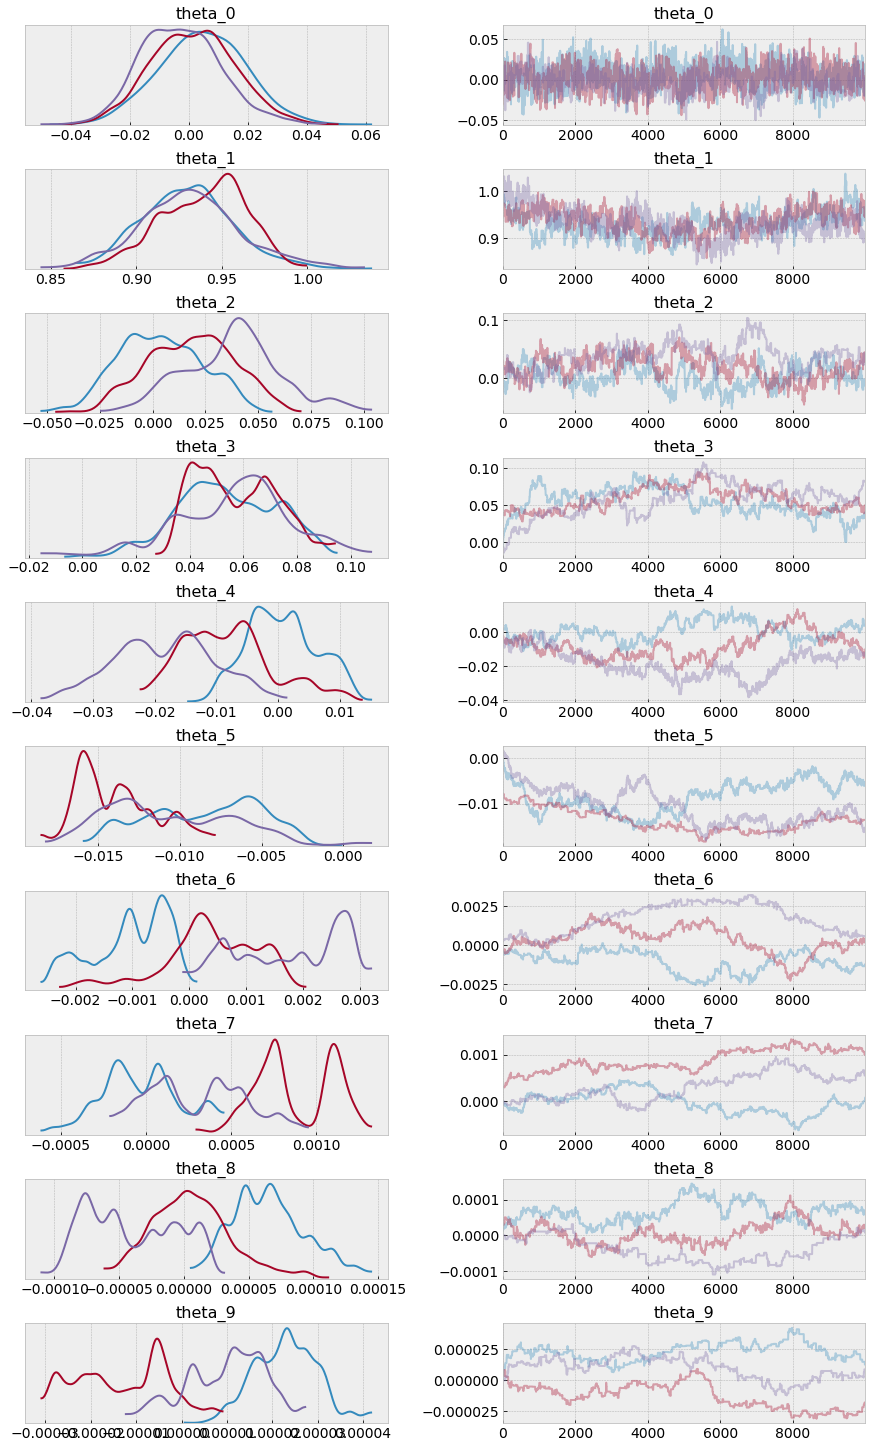

In [27]:
pm.traceplot(trace);

Now we can get the mean value for regression

In [28]:
theta = [trace[f'theta_{i}'].mean() for i in polynoms_n]

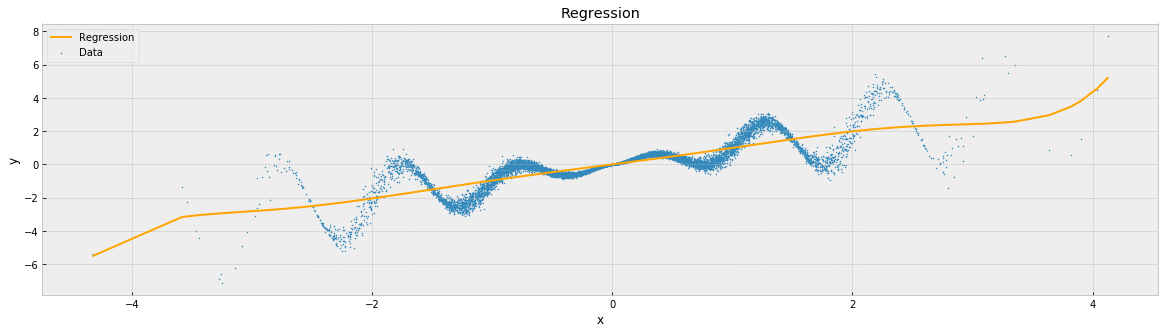

In [29]:
_y = sum([theta[i] * x ** i for i in polynoms_n])
plt.figure(figsize=(20, 5))
plt.scatter(x, y, label='Data', s=1)
plt.plot(x, _y, label='Regression', c='orange')
plt.title('Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show();

## Variational Inference

### Introduction

In a ML problem, we want to aproximate $\hat{f}(X) = Y$. Given that a neural network has weights $w$, we want to maximize the probability $p(Y|w, X)$. During trainning, we adjust $w$ so that $p$ increases. Now for uncertainty we need the posterior probability of weights, i.e., $p(w|Y, X)$. Using Bayes's Theorem:
$$p(w|Y, X) = \frac{p(Y|w, X) \cdot p(w|Y)}{p(X|Y)} = $$
$$= \frac{p(Y|w, X) \cdot p(w|Y)}{p(X|Y)}$$

### The Kullback-Leibler divergence

Given two distributions, $p$ and $q$, we can establish the following similarity [quasimeasure](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence):

$$
\begin{align}
KL(q || p) = \sum_{x}&q(x)\log\left[\frac{q(x)}{p(x)}\right], \qquad\text{Discrete case}\\
KL(q || p) = \int_{-\infty}^\infty &q(x)\log\left[\frac{q(x)}{p(x)}\right]dx, \qquad\text{Continuous case}\\
\end{align}
$$

It's important to tell that it's not completely a distance measure, since $KL(q || p) \neq KL(p || q)$.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x.reshape(x.shape+(1,)), y.reshape(y.shape+(1,)), test_size=0.33)

In [42]:
X_train.shape

(6700, 1)

In [89]:
def variational_network(X_train, y_train):
    # Initialize random weights between each layer
    hidden_shape = (X_train.shape[1], 1000, 100, 10, 1)
    layers_init = [
        np.random.randn(hidden_shape[i], hidden_shape[i+1]).astype(float)
        for i in range(len(hidden_shape)-1)
    ]
    with pm.Model() as neural_network:
        model_input = theano.shared(X_train)
        model_output = theano.shared(y_train)
        layers = [model_input]
        for i, layer in enumerate(layers_init):
            weights = pm.Normal(f'w_{i+1}', 0, sigma=1,
                                shape=layer.shape,
                                testval=layer)
            layers.append(weights)
        #get_shape = theano.printing.Print('vector', attrs = [ 'shape' ])
        #[get_shape(l) for l in layers]
        act = layers[0]
        for layer in layers[1:]:
            act = pm.math.sigmoid(pm.math.dot(act, layer))

        output = pm.Normal('out',
                           act, sigma=1,
                           observed=model_output,
                           total_size=y_train.shape[0] # IMPORTANT for minibatches
                          )
    return model_input, model_output, neural_network

model_input, model_output, neural_network = variational_network(X_train, y_train)

In [90]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=1000, method=inference)

Average Loss = 64,390: 100%|██████████| 1000/1000 [10:16<00:00,  1.93it/s]


In [91]:
trace = approx.sample(1000)

In [92]:
model_input.set_value(X_test)
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

100%|██████████| 500/500 [00:06<00:00, 78.59it/s] 


(-4, 4)

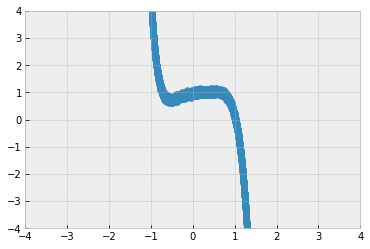

In [97]:
plt.scatter(x, post_pred['y'].mean(axis=0))
plt.xlim(-4, 4)
plt.ylim(-4, 4)

## Monte-Carlo Dropout

In [ ]:
def generate_dropout_model():
    i = Input((1,))
    x = Dense(1000, activation='relu')(i)
    x = Dropout(0.1)(x, training=True)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.1)(x, training=True)
    x = Dense(10, activation='relu')(x)
    x = Dropout(0.1)(x, training=True)
    o = Dense(1, activation='linear')(x)
    m = Model(i, o)
    return m

In [ ]:
x, _, y = data_generator(10000)
dropout_model = generate_dropout_model()
dropout_model.compile(loss='mse', optimizer='adam')
hist = dropout_model.fit(x, y, epochs=100, verbose=1)

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(hist.history['loss'])
plt.title('Model trainning progress')
plt.xlabel('# Epochs')
plt.ylabel('loss (MSE)')
plt.ylim(0)
plt.show()

In [ ]:
preds = []
for i in range(10):
    _y = dropout_model.predict(x)
    preds.append(_y)
predictions = np.array(preds)

plt.figure(figsize=(20, 5))
plt.scatter(x, y, label='Data', s=5)
for i, _y in enumerate(predictions):
    plt.scatter(x, _y, label=f'Regression #{i+1}', c='orange', s=1, alpha=0.1)
plt.title('Regression w/ Dropout')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show();

In [ ]:
mean = predictions.mean(axis=0).flatten()
stdv = predictions.std(axis=0).flatten()

plt.figure(figsize=(20, 5))
plt.plot(x, mean, label='Mean', ms=1, color='orange')
plt.fill_between(x, mean-stdv, mean+stdv, label='Stdev', alpha=0.4)
plt.title('Error Estimation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show();

# References

- https://arxiv.org/pdf/1902.10189.pdf
- https://gdmarmerola.github.io/risk-and-uncertainty-deep-learning/  
- https://arxiv.org/pdf/1905.09638.pdf  
- https://arxiv.org/pdf/1505.05424.pdf  
- https://arxiv.org/pdf/1506.02142.pdf  
- https://arxiv.org/pdf/1602.04621.pdf  
- https://arxiv.org/pdf/1806.03335.pdf  
- https://arxiv.org/pdf/1505.05424.pdf  
- https://arxiv.org/pdf/1601.00670.pdf  
- https://medium.com/@albertoarrigoni/scalable-bayesian-inference-in-python-a6690c7061a3
- https://ermongroup.github.io/cs228-notes/inference/variational/  
- https://github.com/ericmjl/website/blob/master/content/blog/variational-inference-with-pymc3-a-lightweight-demo/linreg.ipynb  
- https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf  
- https://papers.nips.cc/paper/8080-randomized-prior-functions-for-deep-reinforcement-learning.pdf  
- http://proceedings.mlr.press/v37/salimans15.pdf
- https://www.cs.ubc.ca/~schmidtm/Courses/540-W18/L34.pdf
- http://bayesiandeeplearning.org/2016/papers/BDL_4.pdf  
- https://towardsdatascience.com/uncertainty-estimation-for-neural-network-dropout-as-bayesian-approximation-7d30fc7bc1f2  